In [37]:
import glob
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt
import random
import pywt 
from sklearn.model_selection import train_test_split, cross_val_score
from neupy import algorithms

In [29]:
sampling_rate = 173.61  # sampling freq of Adjek

# Folder paths for each set
folders = {
    'A': './data/Z',  # Z000.txt - Z100.txt
    'B': './data/O',  # O000.txt - O100.txt
    'C': './data/N',  # N000.txt - N100.txt
    'D': './data/F',  # F000.txt - F100.txt
    'E': './data/S'   # S000.txt - S100.txt
}

In [33]:
# To store the raw and filtered data
raw_data_all_sets = {key: [] for key in folders.keys()}
filtered_data_all_sets = {key: [] for key in folders.keys()}

# Function to apply a notch filter to remove 50Hz noise
def notch_filter(data, freq=50.0, fs=256.0, Q=30.0):
    """
    Apply a notch filter to remove the 50Hz line noise.
    Parameters:
        data: 1D array of EEG data
        freq: Frequency to remove (50 Hz)
        fs: Sampling rate of the data
        Q: Quality factor (controls bandwidth of the notch)
    """
    w0 = freq / (fs / 2)  # Normalize frequency
    b, a = iirnotch(w0, Q)  # Create notch filter
    filtered_data = filtfilt(b, a, data)  # Apply filter
    return filtered_data

# Function to re-reference the data (average referencing)
def re_reference(data):
    """
    Re-reference the EEG data by subtracting the mean of the signal.
    """
    #return data - np.mean(data)
    return ((data - np.mean(data))/np.std(data))


# Re-reference and filter data for each set
for set_name, folder_path in folders.items():
    # Find all .txt files in the folder
    txt_files = glob.glob(os.path.join(folder_path, "*.txt"))
    
    # Iterate over each file and process the data
    for file in txt_files:
        # Load the data (adjust the delimiter if needed)
        data = pd.read_csv(file, delimiter="\t", header=None)
        
        # Assuming each file contains a single column of EEG data
        eeg_data = data[0].values
        
        # Store raw EEG data before filtering
        raw_data_all_sets[set_name].append(eeg_data)
        
        # Re-reference the EEG data (average reference)
        re_referenced_data = re_reference(eeg_data)
        
        # Apply a notch filter to remove 50Hz noise
        filtered_eeg_data = notch_filter(re_referenced_data, freq=50.0, fs=256.0, Q=30.0)
        
        # Append the filtered data to the respective set
        filtered_data_all_sets[set_name].append(filtered_eeg_data)

# Now raw_data_all_sets contains raw EEG data and filtered_data_all_sets contains re-referenced and filtered EEG data for all sets
for set_name in raw_data_all_sets.keys():
    print(f"Raw data loaded for Set {set_name}: {len(raw_data_all_sets[set_name])} files.")
    print(f"Filtered data loaded for Set {set_name}: {len(filtered_data_all_sets[set_name])} files.")


Raw data loaded for Set A: 100 files.
Filtered data loaded for Set A: 100 files.
Raw data loaded for Set B: 100 files.
Filtered data loaded for Set B: 100 files.
Raw data loaded for Set C: 100 files.
Filtered data loaded for Set C: 100 files.
Raw data loaded for Set D: 100 files.
Filtered data loaded for Set D: 100 files.
Raw data loaded for Set E: 100 files.
Filtered data loaded for Set E: 100 files.


Randomly selected raw and filtered data for Set A (File Index: 58)
Randomly selected raw and filtered data for Set B (File Index: 87)
Randomly selected raw and filtered data for Set C (File Index: 85)
Randomly selected raw and filtered data for Set D (File Index: 83)
Randomly selected raw and filtered data for Set E (File Index: 29)


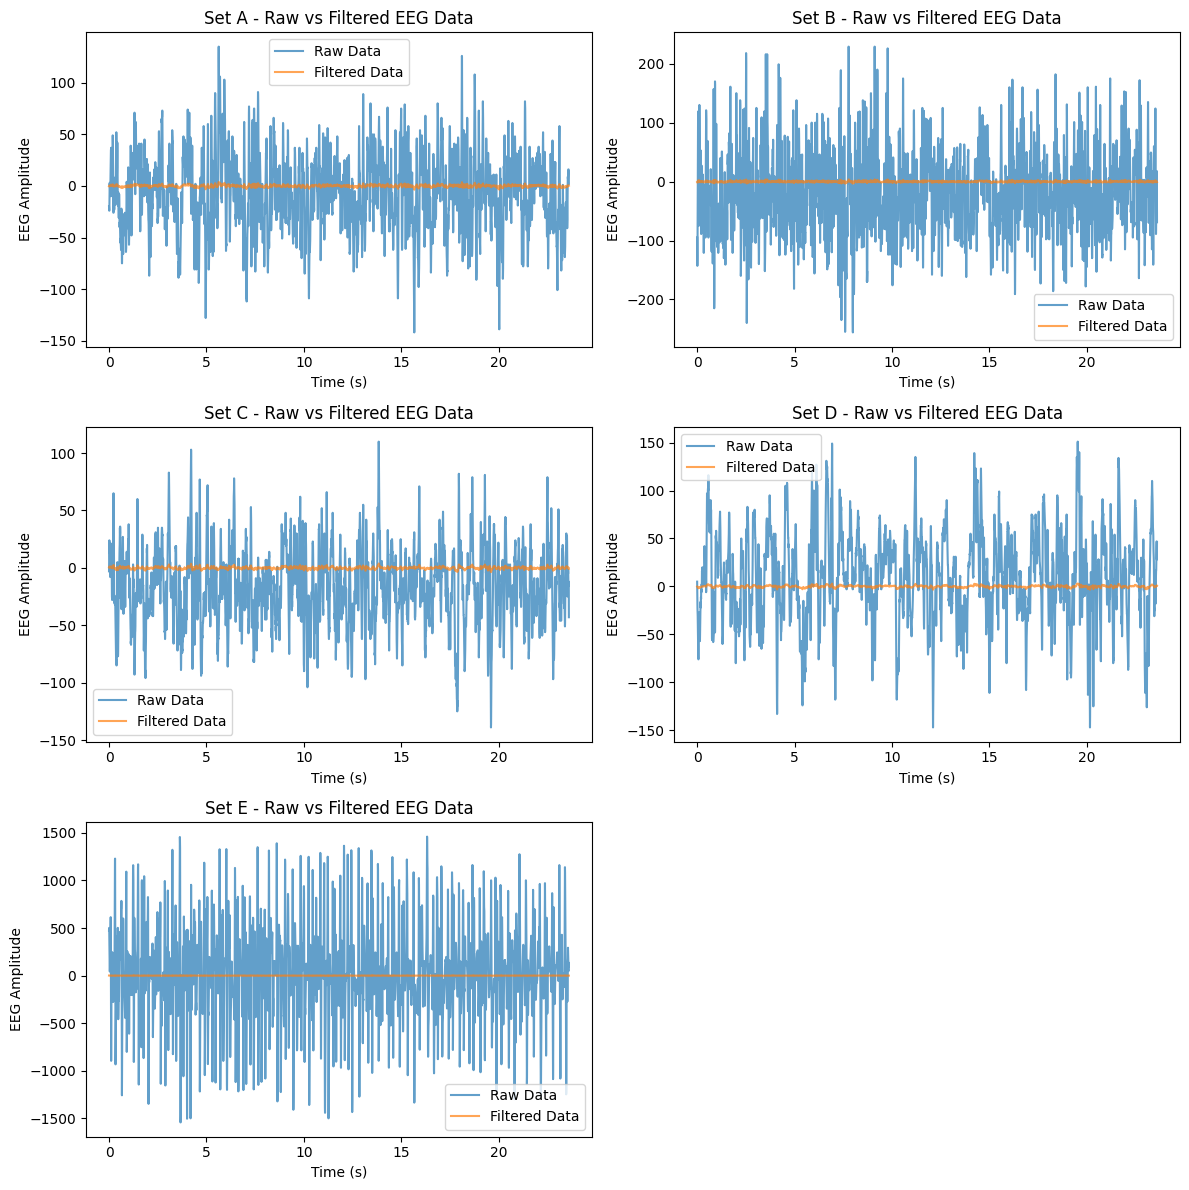

In [34]:
duration = 23.6  # Assuming the duration of the EEG signal is 23.6 seconds

# To store the selected raw and filtered data for plotting
selected_raw_data = {}
selected_filtered_data = {}

# Iterate through each set and randomly select the same file's raw and filtered data
for set_name in raw_data_all_sets.keys():
    
    # Randomly select the index of a file from the list of files
    random_index = random.randint(0, len(raw_data_all_sets[set_name]) - 1)
    
    # Use the same index to select the raw and corresponding filtered data
    random_raw_eeg_data = raw_data_all_sets[set_name][random_index]
    random_filtered_eeg_data = filtered_data_all_sets[set_name][random_index]
    
    print(f"Randomly selected raw and filtered data for Set {set_name} (File Index: {random_index})")
    
    # Store the selected data for plotting
    selected_raw_data[set_name] = random_raw_eeg_data
    selected_filtered_data[set_name] = random_filtered_eeg_data

# Plotting the randomly selected raw and filtered data from each set
plt.figure(figsize=(12, 12))

# Generate time points assuming the same sampling rate and duration
time_points = np.linspace(0, duration, int(sampling_rate * duration))

# Plot each set's raw and filtered data on the same subplot
for i, set_name in enumerate(selected_raw_data.keys(), 1):
    plt.subplot(3, 2, i)  # Create a 3x2 subplot grid
    
    # Plot raw EEG data
    plt.plot(time_points, selected_raw_data[set_name], label='Raw Data', alpha=0.7)
    
    # Plot filtered EEG data
    plt.plot(time_points, selected_filtered_data[set_name], label='Filtered Data', alpha=0.7)
    
    plt.title(f'Set {set_name} - Raw vs Filtered EEG Data')
    plt.xlabel('Time (s)')
    plt.ylabel('EEG Amplitude')
    plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


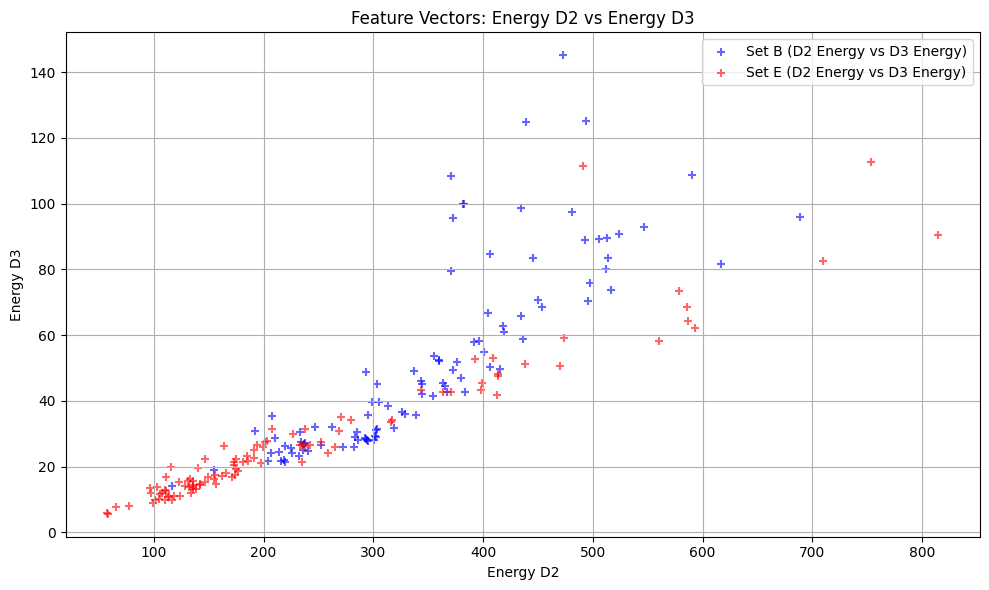

In [43]:
all_sets_data = {key: np.array(val) for key, val in filtered_data_all_sets.items()}

# Function to compute energy of wavelet coefficients
def compute_energy(coefficients):
    return np.sum(np.square(coefficients))

# Wavelet to use for DWT
wavelet = 'coif1'

# level of decomposition
dlevel = 3

# To store feature vectors for each set
feature_vectors_B = []
feature_vectors_E = []

# Process Set B (Blue)
for eeg_data in all_sets_data['B']:
    coeffs_B = pywt.wavedec(eeg_data, wavelet, level=dlevel)  # 3 levels of decomposition
    d2_B = coeffs_B[2]  # D2 coefficients (second detail level)
    d3_B = coeffs_B[3]  # D3 coefficients (third detail level)
    
    # Compute energy for D2 and D3
    d2_energy_B = compute_energy(d2_B)
    d3_energy_B = compute_energy(d3_B)
    
    # Create feature vector for Set B
    feature_vectors_B.append([d2_energy_B, d3_energy_B])

# Process Set E (Red)
for eeg_data in all_sets_data['E']:
    coeffs_E = pywt.wavedec(eeg_data, wavelet, level=dlevel)  # 3 levels of decomposition
    d2_E = coeffs_E[2]  # D2 coefficients (second detail level)
    d3_E = coeffs_E[3]  # D3 coefficients (third detail level)
    
    # Compute energy for D2 and D3
    d2_energy_E = compute_energy(d2_E)
    d3_energy_E = compute_energy(d3_E)
    
    # Create feature vector for Set E
    feature_vectors_E.append([d2_energy_E, d3_energy_E])

# Convert feature vectors to numpy arrays for easy plotting
feature_vectors_B = np.array(feature_vectors_B)
feature_vectors_E = np.array(feature_vectors_E)

# Plot the feature vectors
plt.figure(figsize=(10, 6))

# Plotting feature vectors for Set B
plt.scatter(feature_vectors_B[:, 0], feature_vectors_B[:, 1],  marker='+', color='blue', label='Set B (D2 Energy vs D3 Energy)', alpha=0.6)

# Plotting feature vectors for Set E
plt.scatter(feature_vectors_E[:, 0], feature_vectors_E[:, 1], marker='+', color='red', label='Set E (D2 Energy vs D3 Energy)', alpha=0.6)

# Set plot labels and title
plt.title('Feature Vectors: Energy D2 vs Energy D3')
plt.xlabel('Energy D2')
plt.ylabel('Energy D3')
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the folder paths for the datasets
folders = {
    'B': './data/O',  # Seizure-free
    'E': './data/S'   # Seizure     
}

# To store the features and labels
features = []
labels = []

# Function to compute energy of wavelet coefficients
def compute_energy(coefficients):
    return np.sum(np.square(coefficients))

# Function to extract features from EEG data
def extract_features(eeg_data):
    coeffs = pywt.wavedec(eeg_data, wavelet='db4', level=4)  # Decomposing to 4 levels
    energies = [compute_energy(coeff) for coeff in coeffs]
    return energies

# Load and process data for classification
for set_name, folder_path in folders.items():
    # Find all .txt files in the folder
    txt_files = glob.glob(os.path.join(folder_path, "*.txt"))
    
    for file in txt_files:
        # Load the data (adjust the delimiter if needed)
        data = pd.read_csv(file, delimiter="\t", header=None)
        
        # Assuming each file contains a single column of EEG data
        eeg_data = data[0].values
        
        # Extract features (energy values of DWT coefficients)
        feature_vector = extract_features(eeg_data)
        
        # Append feature vector and corresponding label
        features.append(feature_vector)
        labels.append(1 if set_name == 'E' else 0)  # 1 for seizure, 0 for seizure-free

# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Implement 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store results
accuracy_scores = []

for train_index, test_index in kf.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Create and train the SVM
    svm = SVC(kernel='linear')  # You can choose other kernels as well (e.g., 'rbf', 'poly', etc.)
    svm.fit(X_train, y_train)  # Train the SVM

    # Make predictions
    predictions = svm.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)

# Calculate average accuracy
average_accuracy = np.mean(accuracy_scores)
print(f'Average accuracy over 10-fold cross-validation: {average_accuracy * 100:.2f}%')

Average accuracy over 10-fold cross-validation: 93.50%


In [78]:
all_sets_data = {key: np.array(val) for key, val in filtered_data_all_sets.items() if key in ['C', 'D', 'E']}

In [80]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score

def calculate_energy(coeffs):
    """
    Calculate the energy for detail coefficients (ED_i) and approximation coefficients (EA_i)
    using the formulas provided in the paper.
    """
    ED = np.sum(np.square(coeffs[1]))  # Energy of detail coefficients
    EA = np.sum(np.square(coeffs[0]))  # Energy of approximation coefficients
    return ED, EA

def wavelet_decomposition(signal, wavelet, level):
    """
    Perform wavelet decomposition up to the specified level using the provided wavelet function.
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs

# Assuming data is already preprocessed and normalized
def prepare_data(all_signals):
    """
    Split the dataset into training and testing (7:3 ratio), then perform 10-fold cross-validation.
    """
    # Convert list of signals into features and labels
    features = []
    labels = []
    
    for set_name, signals in all_signals.items():
        label = 1 if set_name == 'E' else 0  # Assuming 'E' is epileptic, others are normal
        for signal in signals:
            # Extract wavelet features for different levels
            coeffs = wavelet_decomposition(signal, 'coif1', level=6)  # Set level=6 initially
            ED, EA = calculate_energy(coeffs)
            features.append([ED, EA])
            labels.append(label)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

# SVM Training Function
def train_svm(X_train, y_train, X_test, y_test):
    svm = SVC(kernel='rbf')  # Using RBF kernel, you can try others like 'linear', 'poly', etc.
    svm.fit(X_train, y_train)
    accuracy = svm.score(X_test, y_test)
    return accuracy

def evaluate_decomposition_levels_with_svm(all_signals, max_level=10):
    results = []
    
    # Iterate over different decomposition levels (1 to max_level)
    for level in range(1, max_level+1):
        features = []
        labels = []
        
        for set_name, signals in all_signals.items():
            label = 1 if set_name == 'E' else 0  # Epileptic signal label
            for signal in signals:
                coeffs = wavelet_decomposition(signal, 'coif1', level=level)
                ED, EA = calculate_energy(coeffs)
                features.append([ED, EA])
                labels.append(label)
        
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
        
        # Train SVM and get accuracy
        accuracy = train_svm(X_train, y_train, X_test, y_test)
        
        results.append((level, accuracy))
        print(f"Decomposition Level {level} - Accuracy: {accuracy:.4f}")
    
    return results

import matplotlib.pyplot as plt

def plot_results(results):
    levels = [r[0] for r in results]
    accuracies = [r[1] for r in results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(levels, accuracies, marker='o')
    plt.title('Decomposition Level vs Classification Accuracy (SVM)')
    plt.xlabel('Decomposition Level')
    plt.ylabel('Classification Accuracy')
    plt.grid(True)
    plt.show()

# Example usage:
results = evaluate_decomposition_levels_with_svm(all_sets_data, max_level=10)
plot_results(results)



Decomposition Level 1 - Accuracy: 0.7000
Decomposition Level 2 - Accuracy: 0.7667
Decomposition Level 3 - Accuracy: 0.8667
Decomposition Level 4 - Accuracy: 0.9000
Decomposition Level 5 - Accuracy: 0.9222
Decomposition Level 6 - Accuracy: 0.9222
Decomposition Level 7 - Accuracy: 0.9000
Decomposition Level 8 - Accuracy: 0.8667
Decomposition Level 9 - Accuracy: 0.6333
Decomposition Level 10 - Accuracy: 0.6444


c:\Users\Hansa Niluka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


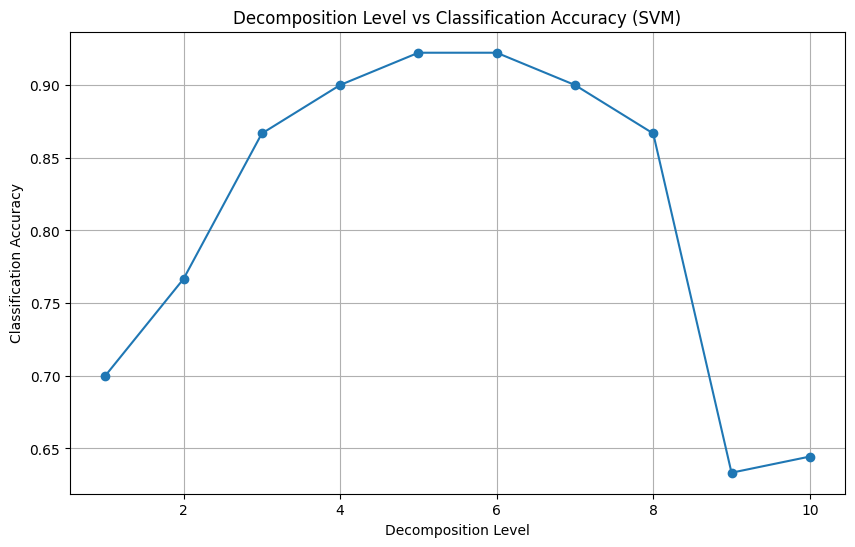